In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [94]:
cd drive/My Drive/dl assn 2/

[Errno 2] No such file or directory: 'drive/My Drive/dl assn 2/'
/content/drive/My Drive/dl assn 2


In [0]:
import torch   

#handling text data
from torchtext import data  
import torch.optim as optim 
import torch.nn as nn
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

In [0]:
tokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
LABEL = data.LabelField()
# fields = [('label', LABEL), ('text',TEXT)]
fields = [(None, None), ('label', LABEL), ('text', TEXT)]
train_data=data.TabularDataset(path = 'p_training_data.csv',fields = fields, format = 'csv',skip_header = True)
valid_data = data.TabularDataset(path = 'p_validation_data.csv',fields = fields, format = 'csv',skip_header = True)

In [0]:
#Cuda algorithms
torch.backends.cudnn.deterministic = True  

**Embedding**

In [98]:
TEXT.build_vocab(train_data,min_freq= 3,vectors = "glove.840B.300d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(LABEL.vocab.freqs.most_common(13))  

#Word dictionary
# print(TEXT.vocab.stoi)  
word_embeddings = TEXT.vocab.vectors 
vocab_size = len(TEXT.vocab)


Size of TEXT vocabulary: 6188
Size of LABEL vocabulary: 13
[('worry', 6684), ('neutral', 4810), ('sadness', 4584), ('happiness', 1730), ('surprise', 1302), ('love', 1276), ('hate', 1109), ('fun', 716), ('relief', 664), ('empty', 532), ('enthusiasm', 358), ('boredom', 146), ('anger', 89)]


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 32

#Load an iterator
train_iter, valid_iter = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [0]:
size_of_vocab = len(TEXT.vocab)
embed_size = 300
max_features = 200

In [0]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train(model, iterator, optimizer, criterion, eps):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    model.cuda()
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text  
        # if (text.size()[0] is not 32):
        #   # print("Here")
        #   # One of the batch returned by BucketIterator has length different than 32.
        #   continue 
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
          text = text.cuda()
          target = target.cuda()

        #convert to 1D tensor
        # predictions = model(text, text_lengths).squeeze()  
        
        predictions = model(text, text_lengths).squeeze()
        # print(predictions.size())
        #compute the loss
        loss = criterion(predictions, batch.label) 
        # print(loss.item())       
        # print(target.size())
        #compute the binary accuracy
        # print(predictions.size())
        acc = (torch.max(predictions, 1)[1].view(target.size()).data == target.data).float().sum()/len(batch)
        if eps == 398:
          print(torch.max(predictions, 1)[1].view(target.size()).data, target.data, "training")
        #backpropage the loss and compute the gradients
        # print(torch.max(predictions, 1)[1].view(target.size()).data, "Predict", target.data)
        # print(torch.min(predictions, 1)[1].view(target.size()).data, "Min")
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    model.cuda()
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
              text = text.cuda()
              target = target.cuda()
            
            #convert to 1d tensor
            # predictions = model(text, text_lengths).squeeze()
            predictions = model(text, text.size()[0]).squeeze()
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = (torch.max(predictions, 1)[1].view(target.size()).data == target.data).float().sum()/len(batch)
            # print(torch.max(predictions, 1)[1].view(target.size()).data, target.data, "val")
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def eval_final(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    y_test = []
    pred_test = []
    #deactivating dropout layers
    model.eval()
    model.cuda()
    val_probas = []
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
              text = text.cuda()
              target = target.cuda()
            
            #convert to 1d tensor
            # predictions = model(text, text_lengths).squeeze()
            predictions = model(text, text.size()[0]).squeeze()
            val_probas.append(predictions)
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = (torch.max(predictions, 1)[1].view(target.size()).data == target.data).float().sum()/len(batch)
            # print(torch.max(predictions, 1)[1].view(target.size()).data, target.data, "val")
            y_test.append(target.data)
            pred_test.append(torch.max(predictions, 1)[1].view(target.size()).data)
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), y_test, pred_test, val_probas

In [0]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad = False)
        
        #lstm layer
        self.rnn = nn.RNN(64, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        self.conv1 = nn.Conv1d(300, 256, kernel_size = 1)
        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 1)
        self.conv2 = nn.Conv1d(256, 128 , kernel_size = 2)
        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.conv3 = nn.Conv1d(128, 64, kernel_size = 1)
        self.pool3 = nn.MaxPool1d(kernel_size = 2, stride = 3)

        #dense layer
        self.fc = nn.Linear(hidden_dim, 13)
        self.attention_layer = Attention(64, 8)
        #activation function
        self.act = nn.Tanh()
        self.dropout = nn.Dropout(p = 0)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        embedded = embedded.permute(0, 2, 1)
        cnn1 = self.conv1(embedded)
        cnn1 = self.dropout(F.relu(cnn1))
        cnn1_p = self.pool1(cnn1)
        cnn2 = self.conv2(cnn1_p)
        cnn2 = self.dropout(F.relu(cnn2))
        cnn2_p = self.pool2(cnn2)
        
        cnn3 = self.conv3(cnn2_p)
        cnn3 = self.dropout(F.relu(cnn3))
        cnn3_p = self.pool3(cnn3)
        cnn3_p = cnn3_p.permute(0, 2, 1)
        
        packed_output, h_n = self.rnn(cnn3_p)
        h_n = self.dropout(h_n)
        h_n = h_n.permute(1, 0, 2) 
        h_lstm_atten = self.attention_layer(h_n)
        outputs=self.fc(h_lstm_atten)
        return outputs

In [103]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 300
hidden_dim = 64
num_output_nodes = 13
num_layers = 4
bidirection = True
dropout = 0.2


model = classifier(size_of_vocab, embedding_dim, hidden_dim, num_output_nodes, num_layers, bidirection, dropout)
optimizer = optim.Adam(model.parameters())
criterion = F.cross_entropy
best_valid_acc = 0
N_EPOCHS = 100
best_valid_loss = float('inf')

train_losses = []
val_losses = []
train_accs = []
val_accs = []
for epoch in range(N_EPOCHS):
     
    #train the model
    # print()
    train_loss, train_acc = train(model, train_iter, optimizer, criterion, epoch)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_accs.append(train_acc)
    val_accs.append(valid_acc)

    #save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'novel_attn_0.pt')
        torch.save(model, 'novel_attn_0')
    
    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Loss: 2.036 | Train Acc: 29.75% | Val. Loss: 2.345 |  Val. Acc: 20.88%
Train Loss: 1.958 | Train Acc: 31.99% | Val. Loss: 2.110 |  Val. Acc: 29.07%
Train Loss: 1.901 | Train Acc: 33.28% | Val. Loss: 2.126 |  Val. Acc: 29.49%
Train Loss: 1.876 | Train Acc: 33.91% | Val. Loss: 2.066 |  Val. Acc: 31.48%
Train Loss: 1.853 | Train Acc: 34.57% | Val. Loss: 2.039 |  Val. Acc: 32.78%
Train Loss: 1.820 | Train Acc: 36.01% | Val. Loss: 2.020 |  Val. Acc: 33.36%
Train Loss: 1.793 | Train Acc: 36.95% | Val. Loss: 2.024 |  Val. Acc: 34.49%
Train Loss: 1.771 | Train Acc: 37.73% | Val. Loss: 2.090 |  Val. Acc: 32.46%
Train Loss: 1.743 | Train Acc: 39.26% | Val. Loss: 2.164 |  Val. Acc: 31.88%
Train Loss: 1.716 | Train Acc: 40.30% | Val. Loss: 2.019 |  Val. Acc: 34.76%
Train Loss: 1.691 | Train Acc: 41.40% | Val. Loss: 2.071 |  Val. Acc: 34.08%
Train Loss: 1.666 | Train Acc: 42.48% | Val. Loss: 2.136 |  Val. Acc: 32.56%
Train Loss: 1.641 | Train Acc: 43.54% | Val. Loss: 2.119 |  Val. Acc: 32.56%

KeyboardInterrupt: ignored

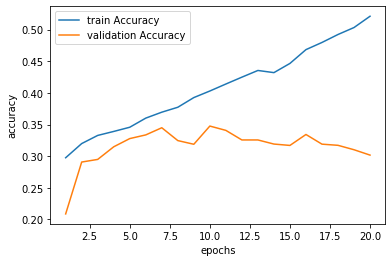

In [104]:
import matplotlib.pyplot as plt

epoch_list = []
for i in range(20):
  epoch_list.append(i + 1)
plt.plot(epoch_list, train_accs[:20])
plt.plot(epoch_list, val_accs[:20])
plt.legend(["train Accuracy", "validation Accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("novel_acc_0.jpeg", dpi = 500, format = "jpeg")
plt.show()

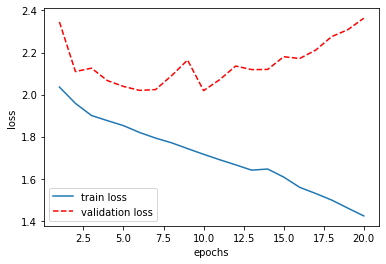

In [105]:
# plot loss
plt.plot(epoch_list, train_losses[:20])
plt.plot(epoch_list, val_losses[:20], '--r')
plt.legend(["train loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("novel_loss_0.jpeg", dpi = 500, format = "jpeg")
plt.show()

Val. Loss: 2.019 |  Val. Acc: 0.35%


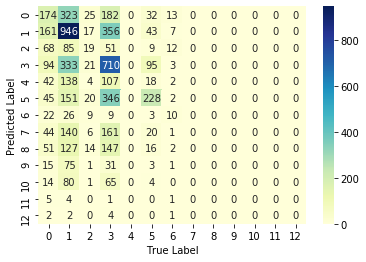

In [106]:
model = torch.load('novel_attn_0')
import numpy as np
# evaluate the model
valid_loss, valid_acc, y_test, pred_test, val_probas = eval_final(model, valid_iter, criterion)

print(f'Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

def return_labels(tensor_list):
  new_list = np.array(tensor_list)
  labels = []
  for i in range(new_list.shape[0]):
    labels.append(new_list[i].squeeze().tolist())
  final_labels = []
  for i in range(len(labels)):
    for j in range(len(labels[i])):
      final_labels.append(labels[i][j])
  return final_labels

y_test = return_labels(y_test)
pred_test = return_labels(pred_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test)

import seaborn as sns
%matplotlib inline
sns.heatmap(cm, annot=True, cbar=True, cmap = 'YlGnBu', fmt = 'd')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
# plt.title('Confusion Matrix')
plt.savefig("cm_novel_0.jpeg", dpi = 500, format = 'jpeg')

In [0]:
def get_prob(probas):
  probas = np.array(probas)
  prob = []
  for i in range(probas.shape[0]):
    for j in range(len(probas[i])):
      prob.append(probas[i][j])
  prob = np.array(prob)
  rm_tensor = []
  for i in range(prob.shape[0]):
    rm_tensor.append(prob[i].squeeze().tolist())
  rm_tensor = np.array(rm_tensor)
  return rm_tensor

In [0]:
prob = get_prob(val_probas)

In [109]:
!pip install scikit-plot
import scikitplot as skplt

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


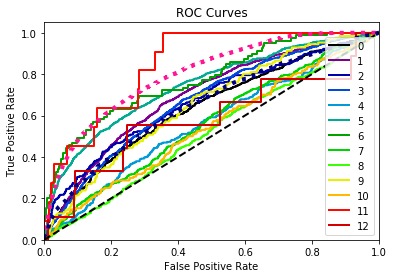

In [110]:
skplt.metrics.plot_roc_curve(y_test, prob)
plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
plt.savefig("roc_novel_0.jpeg", dpi = 500, format = "jpeg")
plt.show()